In [1]:
import numpy as np
import trimesh as tm # https://github.com/mikedh/trimesh
from time import time
import sys
sys.path.append(r'C:\Users\Varian\source\repos\vmspy')  # path to vmspy repo

import pysapi
pysapi.SAFE_MODE = False # make 3D array build go faster
#load app only once
app = pysapi.CustomScriptExecutable.CreateApplication('mmf_raymesh')  # script name is used for logging

In [2]:
patient = app.OpenPatientById("001")

In [3]:
plan = patient.CoursesLot(0).PlanSetupsLot(0)

In [4]:
structure = plan.StructureSet.StructuresLot('body')

In [59]:
expanded_field_size = 100. # mm
beamlet_size_x = beamlet_size_z = 5.0  # mm

time: 2.080770254135132


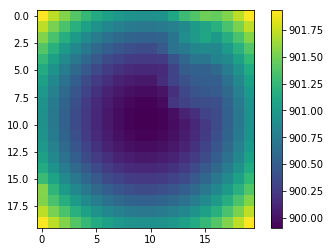

In [65]:
tic = time()

iso = plan.BeamsLot(0).IsocenterPosition

meshgeo = structure.MeshGeometry
verts = np.array([(_.X-iso.x, _.Y-iso.y, _.Z-iso.z) for _ in meshgeo.Positions])
faces = np.array([_ for _ in structure.MeshGeometry.TriangleIndices]).reshape((-1,3))
mesh = tm.Trimesh(vertices=verts,faces=faces)

# tic = time()

# compute CENTRAL POINTS of pixels on fluence map
x_map_centers = np.linspace(-expanded_field_size / 2. + beamlet_size_x / 2,
                            expanded_field_size / 2. - beamlet_size_x / 2.,
                            int(expanded_field_size / beamlet_size_x))

z_map_centers = np.linspace(-expanded_field_size / 2. + beamlet_size_z / 2,
                            expanded_field_size / 2. - beamlet_size_z / 2.,
                            int(expanded_field_size / beamlet_size_z))

x_mesh_centers, z_mesh_centers = np.meshgrid(x_map_centers, z_map_centers)

num_bixels = x_mesh_centers.shape[0]*z_mesh_centers.shape[0]

src_pts = np.array([0.0,1000.0,0.0]*num_bixels).reshape((-1,3)) # mm
iso_plane = np.array([x_mesh_centers.flatten(), [0.0]*num_bixels ,z_mesh_centers.flatten()]).T
assert iso_plane.shape == src_pts.shape

intersections = mesh.ray.intersects_location(ray_origins=src_pts,ray_directions=iso_plane-src_pts)

locations = intersections[0]
ray_idxs = intersections[1]
dist_map = np.ones_like(x_mesh_centers)*np.inf
for i,idx in enumerate(ray_idxs):
    temp_dist = np.sqrt(np.square(locations[i]-src_pts[idx]).sum())
    if(temp_dist < dist_map.flat[idx]):
        dist_map.flat[idx] = temp_dist

print("time:",time()-tic)

from matplotlib import pyplot as plt
plt.imshow(dist_map)
plt.colorbar()
plt.show()